In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A
import glob
from shapely.geometry import Polygon

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 45em; }</style>"))
pd.options.display.max_columns = None

/tmp/ipykernel_9905/2198079538.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(300, 32),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGG_model()
model.load_state_dict(torch.load('./Model_VGG_4_5_2000_13080_epoch'))
model = model.to(device)

In [5]:
def predict_keypoints(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    img_normalised = img_normalised.to(device)
    
    key_points = model(img_normalised[None]).flatten().detach().cpu().numpy()
    
    return key_points

In [6]:
def plot_keypoints(img, keypoints):                                                             

    plt.imshow(img)

    keypoints = np.array(keypoints)
    
    x_points = keypoints[0::2]
    y_points = keypoints[1::2]
    
    plt.scatter(x_points*img.shape[1], y_points*img.shape[0], s = 4, c=(1,0,0))
    plt.show()

In [7]:
def process_num(x):
    return x*random.uniform(0.95, 1.05)

In [8]:
def process_label(x):
    string_to_int_dict = {'orange':0, 'pear':1, 'banana':2, 'plum':3, 'egg':4, 'strawberry':5, 'chicken':6, 'bayberry':7, 'redgrape':8, 'pistachio':9}
    return string_to_int_dict[x]


In [9]:
def transform_image(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    return img_normalised

In [12]:
def augment_data():

    source_folder = os.path.join(os. getcwd(), 'Grasp_dataset_2')
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    for f in dataset_names:
        
        files = glob.glob(destination_folder + '/' + f + '/*')
        
        for file in files:
            os.remove(file)
        
        df = pd.read_csv(source_folder + '/' + f + '/' + f + '.csv')
        
        num_cols = df.select_dtypes(include=['float']).columns
        df[num_cols] = df[num_cols].applymap(process_num)
        df['label'] = df['label'].apply(process_label)
        
#         df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)
        
        i = 0
        repeat = 0
        
        header = ['p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y',
              'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x',
              'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y']
            
        keypoints_df = pd.DataFrame(columns=header)
        
        while i < df.shape[0]:
        
            transform = A.Compose([
                    A.Affine(rotate=random.uniform(-1, 1), p=1),
                    A.Affine(translate_percent={'x': random.uniform(-0.02, 0.02), 'y': random.uniform(-0.02, 0.02)}, p=1),
                    A.Affine(shear={'x': random.uniform(-1, 1), 'y': random.uniform(-0.5, 0.5)}, p=1),
                    A.Affine(scale=(0.98, 1.01), p=1)
                ], keypoint_params=A.KeypointParams(format='xy'))
            
            image_to_be_transformed = cv2.imread(os.path.join(source_folder + '/' + f, df.iloc[i]['image_name']))
            
            processed_image_to_be_transformed = transform_image(image_to_be_transformed)
            processed_image_to_be_transformed = processed_image_to_be_transformed.to(device)

            keypoints = model(processed_image_to_be_transformed[None]).flatten().detach().cpu().numpy()
            
            x_points = keypoints[0::2]
            y_points = keypoints[1::2]
            x_points = x_points*image_to_be_transformed.shape[1]
            y_points = y_points*image_to_be_transformed.shape[0]

            transformed = transform(image=image_to_be_transformed, keypoints=list(zip(x_points, y_points)))
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
            
            if repeat >= 20:
                print('skipping')
                repeat = 0
                i = i + 1
                continue
    
            if len(transformed_keypoints) != 16:
#                 print(df.iloc[i]['image_name'])
                repeat = repeat + 1
                continue
            
            flatten_coordinates = np.array(transformed_keypoints).flatten()
            flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
            flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
            keypoints_df.loc[len(keypoints_df)] = pd.Series(flatten_coordinates, index=header)
#             print(flatten_coordinates)
#             print(keypoints_df)
            
            transformed_image[..., [0, 2]] = transformed_image[..., [2, 0]]
            img = Image.fromarray(np.uint8(transformed_image))
            img.save(destination_folder + '/' + f + '/' + df.iloc[i]['image_name'])
            
#             plot_keypoints(transformed_image, flatten_coordinates)
            
            repeat = 0
            i = i + 1
        
        complete_df = pd.concat([df, keypoints_df], axis=1)
        complete_df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)


In [ ]:
# test_image = cv2.imread('/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Grasp_dataset_augmented/Grasp_dataset_orange/Gimage10.jpg')
# test_keypoints = [0.12771776,0.2779994,0.47523814,0.025530297,0.8148705,0.2775899,0.8246956,0.62812585,0.49508992,0.9256545,0.15821105,0.73071223,0.43649036,0.20082472,0.40966305,0.36028758,0.39995593,0.49125895,0.41422606,0.61616457,0.44915825,0.75999326,0.52863693,0.7681227,0.5525919,0.6140371,0.5610489,0.49106207,0.5443897,0.3638414,0.51417565,0.20984803]
# print(len(test_keypoints))
# plot_keypoints(test_image, test_keypoints)

In [13]:
def combine_datasets():

    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    complete_df_set = pd.DataFrame()
    first_dataset = True

    for f in dataset_names:

        df = pd.read_csv(destination_folder + '/' + f + '/' + f + '.csv')

        if first_dataset == True:
            complete_df_set = df
            first_dataset = False
        else:
            complete_df_set = pd.concat([complete_df_set, df], axis=0)

    complete_df_set.to_csv(destination_folder + '/' + 'Grasp_dataset_augmented.csv', index=False)


In [14]:
augment_data()
combine_datasets()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# augment_data()
# combine_datasets()

# grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')

# print(grasp_dataset.tail(2))


# data_train, data_test, label_train, label_test = train_test_split(grasp_data, grasp_label, test_size=0.2, random_state=np.random.randint(100))

# clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=np.random.randint(100))

# num_folds = 10
# cv_method = KFold(n_splits=num_folds, shuffle=True, random_state=np.random.randint(100))
# cv_results = cross_val_score(clf, grasp_data, grasp_label, cv=cv_method, scoring='accuracy')

# print('Cross-validation results:', cv_results)
# print('Average accuracy:', cv_results.mean())


In [15]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data, self.label = self.clean_data(df) # clean data
        
        
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        label = self.label.iloc[idx]
#         label = F.one_hot(torch.tensor(label), 10)
        
        return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.int64).to(device)
    
    def __len__(self):
        return self.data.shape[0]

    
    def clean_data(self, grasp_dataset):
        grasp_data = grasp_dataset.drop(columns=['image_name', 'label'], axis=1)
        grasp_data['pressure_reading_1'] = grasp_data['pressure_reading_1'] / 100
        grasp_data['pressure_reading_2'] = grasp_data['pressure_reading_2'] / 100
        grasp_data['force_reading_1'] = grasp_data['force_reading_1'] / 1000
        grasp_data['force_reading_2'] = grasp_data['force_reading_2'] / 1000
        grasp_label = grasp_dataset['label']

        return grasp_data, grasp_label

In [ ]:
# grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')

# train_df, test_df = train_test_split(grasp_dataset, test_size=0.1)

# train_dataset = ClassifierDataset(train_df)
# test_dataset = ClassifierDataset(test_df)

# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

# for data in train_dataloader:
#     break

# input_data, target_output = data
# print(input_data)
# print(target_output)

In [16]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(16*2+4, 64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.layers(x)



In [17]:
classification_model = MLP()
classification_model = classification_model.to(device)

In [18]:
summary(classification_model, (8,16*2+4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 8, 64]           2,368
         LeakyReLU-2                [-1, 8, 64]               0
           Dropout-3                [-1, 8, 64]               0
            Linear-4                [-1, 8, 32]           2,080
         LeakyReLU-5                [-1, 8, 32]               0
           Dropout-6                [-1, 8, 32]               0
            Linear-7                [-1, 8, 10]             330
Total params: 4,778
Trainable params: 4,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [19]:
def update_training_set():

    global train_df, test_df, train_dataset, test_dataset, train_dataloader, test_dataloader, image_data
    
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')

    augment_data()
    combine_datasets()
    
    grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')
    
    train_df, test_df = train_test_split(grasp_dataset, test_size=0.1)
    
    train_dataset = ClassifierDataset(train_df)
    test_dataset = ClassifierDataset(test_df)
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
    
    print('Finished.')

In [20]:
update_training_set()

Finished.


In [21]:
def get_essentials():
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [22]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    input_data, target_output = data
    pred_output = model(input_data)
    loss = loss_fun(pred_output, target_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    input_data, target_output = data
    pred_output = model(input_data.to(torch.float32))
    loss = loss_fun(pred_output, target_output)
    return loss.item()


In [23]:
epochs = 1000
loss_fun, optimizer = get_essentials()

In [24]:
train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, classification_model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)
    for data in test_dataloader:
        val_batch_loss = val_batch(data, classification_model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

    if epoch % 5 == 0:
        print(train_batch_loss, val_batch_loss)
    
    if (epoch) % 100 == 0:
        torch.save(classification_model.state_dict(), './Temp_models/Model_classify_dataset_2' + str(epoch) + '_epoch')
        update_training_set()

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

2.378467082977295 2.217446804046631


  0%|                                        | 2/1000 [00:11<1:15:50,  4.56s/it]

Finished.


  1%|▎                                         | 8/1000 [00:11<08:06,  2.04it/s]

2.2825374603271484 2.337021827697754


  1%|▍                                        | 12/1000 [00:12<04:11,  3.93it/s]

2.334653615951538 2.293644428253174


  2%|▋                                        | 16/1000 [00:12<02:46,  5.90it/s]

2.334153652191162 2.359131336212158


  2%|▉                                        | 22/1000 [00:13<02:00,  8.14it/s]

2.3207483291625977 2.22988224029541


  3%|█                                        | 27/1000 [00:13<01:42,  9.54it/s]

2.2900843620300293 2.241204261779785


  3%|█▎                                       | 33/1000 [00:14<01:37,  9.91it/s]

2.350480079650879 2.257180690765381


  4%|█▌                                       | 38/1000 [00:14<01:36,  9.99it/s]

2.2328343391418457 2.250152587890625


  4%|█▋                                       | 42/1000 [00:15<01:37,  9.82it/s]

2.1531710624694824 2.296877384185791


  5%|█▉                                       | 48/1000 [00:15<01:39,  9.53it/s]

2.2585902214050293 1.9326179027557373


  5%|██▏                                      | 53/1000 [00:16<01:35,  9.93it/s]

1.7605382204055786 2.0186522006988525


  6%|██▍                                      | 58/1000 [00:16<01:33, 10.09it/s]

2.315606117248535 1.7754714488983154


  6%|██▌                                      | 62/1000 [00:17<01:35,  9.78it/s]

1.9859466552734375 1.994181513786316


  7%|██▋                                      | 67/1000 [00:17<01:37,  9.61it/s]

1.789759874343872 1.9784928560256958


  7%|██▉                                      | 72/1000 [00:18<01:36,  9.61it/s]

1.3358161449432373 2.019596576690674


  8%|███▏                                     | 77/1000 [00:18<01:35,  9.64it/s]

1.8798561096191406 1.6603376865386963


  8%|███▎                                     | 82/1000 [00:19<01:34,  9.68it/s]

1.4311243295669556 1.5155413150787354


  9%|███▌                                     | 87/1000 [00:19<01:35,  9.60it/s]

1.6413390636444092 1.7085580825805664


  9%|███▊                                     | 92/1000 [00:20<01:32,  9.87it/s]

1.5108280181884766 2.264014720916748


 10%|███▉                                     | 97/1000 [00:20<01:31,  9.90it/s]

1.3457920551300049 1.6263692378997803


 10%|████                                    | 100/1000 [00:21<01:32,  9.75it/s]

2.010098695755005 1.5208985805511475


 10%|████                                    | 102/1000 [00:33<37:02,  2.47s/it]

Finished.


 11%|████▎                                   | 107/1000 [00:33<09:26,  1.58it/s]

1.668849229812622 0.8028788566589355


 11%|████▍                                   | 112/1000 [00:34<03:03,  4.85it/s]

1.9609360694885254 1.1535086631774902


 12%|████▋                                   | 117/1000 [00:34<01:48,  8.17it/s]

1.7415196895599365 1.751462459564209


 12%|████▉                                   | 122/1000 [00:35<01:33,  9.38it/s]

1.3793190717697144 1.6081942319869995


 13%|█████                                   | 128/1000 [00:36<01:28,  9.82it/s]

2.022967576980591 1.3364415168762207


 13%|█████▎                                  | 132/1000 [00:36<01:27,  9.91it/s]

1.3306469917297363 1.72121000289917


 14%|█████▍                                  | 137/1000 [00:37<01:28,  9.77it/s]

1.9165772199630737 1.5818551778793335


 14%|█████▋                                  | 142/1000 [00:37<01:29,  9.58it/s]

1.476278305053711 1.4691649675369263


 15%|█████▉                                  | 147/1000 [00:38<01:26,  9.87it/s]

1.192687749862671 1.5776302814483643


 15%|██████                                  | 152/1000 [00:38<01:26,  9.83it/s]

1.4879937171936035 1.5182693004608154


 16%|██████▎                                 | 157/1000 [00:39<01:27,  9.68it/s]

0.9782512187957764 1.4832850694656372


 16%|██████▍                                 | 162/1000 [00:39<01:26,  9.69it/s]

1.933409333229065 1.3632811307907104


 17%|██████▋                                 | 167/1000 [00:40<01:26,  9.67it/s]

1.2785370349884033 1.3401875495910645


 17%|██████▉                                 | 172/1000 [00:40<01:23,  9.91it/s]

1.4191222190856934 0.991507887840271


 18%|███████                                 | 177/1000 [00:41<01:21, 10.14it/s]

1.3291646242141724 2.041508197784424


 18%|███████▎                                | 183/1000 [00:41<01:21, 10.03it/s]

1.8834017515182495 1.0683636665344238


 19%|███████▍                                | 187/1000 [00:42<01:36,  8.46it/s]

1.5516242980957031 1.2847800254821777


 19%|███████▋                                | 192/1000 [00:42<01:28,  9.13it/s]

1.1335541009902954 1.2414640188217163


 20%|███████▉                                | 197/1000 [00:43<01:25,  9.34it/s]

1.3524318933486938 0.9627383947372437


 20%|████████                                | 200/1000 [00:43<01:25,  9.34it/s]

1.4447989463806152 1.0281739234924316


 20%|████████                                | 202/1000 [00:56<37:32,  2.82s/it]

Finished.


 21%|████████▎                               | 207/1000 [00:57<07:27,  1.77it/s]

1.426777958869934 1.4159388542175293


 21%|████████▍                               | 212/1000 [00:57<02:24,  5.47it/s]

1.6039515733718872 1.0207356214523315


 22%|████████▋                               | 217/1000 [00:58<01:32,  8.49it/s]

1.0354833602905273 1.469823956489563


 22%|████████▉                               | 222/1000 [00:58<01:22,  9.39it/s]

1.0531022548675537 1.2511041164398193


 23%|█████████                               | 227/1000 [00:59<01:20,  9.55it/s]

1.2591092586517334 1.5149664878845215


 23%|█████████▎                              | 232/1000 [00:59<01:20,  9.60it/s]

0.6384178400039673 1.0816805362701416


 24%|█████████▍                              | 237/1000 [01:00<01:21,  9.37it/s]

1.477626085281372 1.2888553142547607


 24%|█████████▋                              | 242/1000 [01:01<01:22,  9.16it/s]

1.2244274616241455 1.2369893789291382


 25%|█████████▉                              | 247/1000 [01:01<01:21,  9.20it/s]

1.5724784135818481 0.8071463108062744


 25%|██████████                              | 252/1000 [01:02<01:21,  9.14it/s]

1.1373674869537354 1.363659143447876


 26%|██████████▎                             | 257/1000 [01:02<01:19,  9.33it/s]

1.4737393856048584 0.9934096336364746


 26%|██████████▍                             | 262/1000 [01:03<01:18,  9.35it/s]

0.9321154952049255 0.8663961887359619


 27%|██████████▋                             | 267/1000 [01:03<01:18,  9.35it/s]

1.632962942123413 0.6839192509651184


 27%|██████████▉                             | 272/1000 [01:04<01:34,  7.74it/s]

1.7419047355651855 1.0356343984603882


 28%|███████████                             | 277/1000 [01:04<01:19,  9.06it/s]

1.5127546787261963 1.3475679159164429


 28%|███████████▎                            | 282/1000 [01:05<01:16,  9.43it/s]

1.3353257179260254 1.1906899213790894


 29%|███████████▍                            | 287/1000 [01:06<01:18,  9.03it/s]

0.9673268795013428 1.336543321609497


 29%|███████████▋                            | 293/1000 [01:06<01:13,  9.66it/s]

1.2436540126800537 0.9464282989501953


 30%|███████████▉                            | 297/1000 [01:07<01:13,  9.51it/s]

0.903623104095459 0.8853678703308105


 30%|████████████                            | 300/1000 [01:07<01:13,  9.54it/s]

0.5651837587356567 1.209902286529541


 30%|████████████                            | 302/1000 [01:21<34:10,  2.94s/it]

Finished.


 31%|████████████▎                           | 307/1000 [01:21<06:44,  1.71it/s]

0.7239483594894409 0.8625878095626831


 31%|████████████▍                           | 312/1000 [01:22<02:11,  5.24it/s]

1.30037522315979 0.7138326168060303


 32%|████████████▋                           | 317/1000 [01:22<01:25,  8.00it/s]

1.2393977642059326 0.6708350777626038


 32%|████████████▉                           | 322/1000 [01:23<01:18,  8.61it/s]

1.0168488025665283 0.8402543067932129


 33%|█████████████                           | 327/1000 [01:23<01:17,  8.71it/s]

1.1707615852355957 0.9323196411132812


 33%|█████████████▎                          | 332/1000 [01:24<01:14,  9.02it/s]

0.663444995880127 1.0538791418075562


 34%|█████████████▍                          | 337/1000 [01:25<01:10,  9.45it/s]

1.2998030185699463 1.2590185403823853


 34%|█████████████▋                          | 342/1000 [01:25<01:16,  8.61it/s]

0.9870665073394775 0.7063077688217163


 35%|█████████████▉                          | 347/1000 [01:26<01:09,  9.46it/s]

1.2798728942871094 0.7996194362640381


 35%|██████████████                          | 352/1000 [01:26<01:17,  8.39it/s]

1.2453327178955078 0.8190257549285889


 36%|██████████████▎                         | 357/1000 [01:27<01:12,  8.82it/s]

0.9070547223091125 0.7890071868896484


 36%|██████████████▍                         | 362/1000 [01:27<01:13,  8.72it/s]

1.2194273471832275 1.7707104682922363


 37%|██████████████▋                         | 367/1000 [01:28<01:07,  9.37it/s]

0.5918797254562378 1.1184277534484863


 37%|██████████████▉                         | 372/1000 [01:28<01:05,  9.53it/s]

1.6771001815795898 0.7827126979827881


 38%|███████████████                         | 377/1000 [01:29<01:05,  9.45it/s]

0.5295965671539307 1.0763214826583862


 38%|███████████████▎                        | 382/1000 [01:30<01:10,  8.75it/s]

0.6670344471931458 0.22531813383102417


 39%|███████████████▍                        | 387/1000 [01:30<01:13,  8.38it/s]

0.738667905330658 0.8663405179977417


 39%|███████████████▋                        | 392/1000 [01:31<01:13,  8.23it/s]

0.8418529033660889 1.3393322229385376


 40%|███████████████▉                        | 397/1000 [01:31<01:06,  9.13it/s]

1.3479442596435547 0.9934262037277222


 40%|████████████████                        | 400/1000 [01:32<01:11,  8.44it/s]

0.5874607563018799 1.0503509044647217


 40%|████████████████                        | 402/1000 [01:45<28:50,  2.89s/it]

Finished.


 41%|████████████████▎                       | 408/1000 [01:46<05:21,  1.84it/s]

1.1923332214355469 0.968433678150177


 41%|████████████████▍                       | 412/1000 [01:46<02:48,  3.48it/s]

1.4630788564682007 0.9237946271896362


 42%|████████████████▋                       | 418/1000 [01:47<01:20,  7.23it/s]

1.5159382820129395 1.0991108417510986


 42%|████████████████▉                       | 422/1000 [01:47<01:07,  8.58it/s]

1.0747416019439697 1.043729543685913


 43%|█████████████████                       | 427/1000 [01:48<01:01,  9.25it/s]

0.8293616771697998 1.9234049320220947


 43%|█████████████████▎                      | 432/1000 [01:48<01:10,  8.10it/s]

0.46074962615966797 0.7951245307922363


 44%|█████████████████▍                      | 437/1000 [01:49<01:02,  8.95it/s]

1.1175575256347656 1.4000195264816284


 44%|█████████████████▋                      | 442/1000 [01:50<00:58,  9.54it/s]

0.396648108959198 0.6698654294013977


 45%|█████████████████▉                      | 447/1000 [01:50<01:02,  8.87it/s]

0.5439940690994263 0.8952181339263916


 45%|██████████████████                      | 452/1000 [01:51<01:01,  8.87it/s]

1.0431737899780273 1.1001746654510498


 46%|██████████████████▎                     | 457/1000 [01:51<00:59,  9.17it/s]

0.7109097242355347 1.1311079263687134


 46%|██████████████████▍                     | 462/1000 [01:52<00:58,  9.18it/s]

0.9456179141998291 0.9897215962409973


 47%|██████████████████▋                     | 466/1000 [01:52<01:04,  8.25it/s]

1.3362364768981934 1.0470008850097656


 47%|██████████████████▉                     | 472/1000 [01:53<01:00,  8.71it/s]

0.7699209451675415 0.6274645924568176


 48%|███████████████████                     | 477/1000 [01:54<00:57,  9.05it/s]

1.2108139991760254 1.689190149307251


 48%|███████████████████▎                    | 482/1000 [01:54<00:57,  8.97it/s]

0.4132573902606964 0.8973082304000854


 49%|███████████████████▍                    | 487/1000 [01:55<00:55,  9.22it/s]

1.2103643417358398 0.570738673210144


 49%|███████████████████▋                    | 492/1000 [01:55<00:55,  9.23it/s]

0.7192699909210205 1.6767709255218506


 50%|███████████████████▉                    | 497/1000 [01:56<00:54,  9.28it/s]

1.2852994203567505 0.8135216236114502


 50%|████████████████████                    | 500/1000 [01:56<00:52,  9.52it/s]

0.7795650362968445 1.0605323314666748


 50%|████████████████████                    | 502/1000 [02:09<22:58,  2.77s/it]

Finished.


 51%|████████████████████▎                   | 508/1000 [02:10<03:39,  2.24it/s]

0.9849996566772461 1.644921064376831


 51%|████████████████████▍                   | 512/1000 [02:10<01:43,  4.72it/s]

0.9510056376457214 1.020085334777832


 52%|████████████████████▋                   | 517/1000 [02:11<01:06,  7.24it/s]

0.7313956618309021 1.3497490882873535


 52%|████████████████████▉                   | 522/1000 [02:11<00:56,  8.50it/s]

1.1249260902404785 1.5006799697875977


 53%|█████████████████████                   | 527/1000 [02:12<00:50,  9.33it/s]

0.7094186544418335 0.8357727527618408


 53%|█████████████████████▎                  | 532/1000 [02:12<00:49,  9.37it/s]

1.386255145072937 1.6148006916046143


 54%|█████████████████████▍                  | 537/1000 [02:13<00:50,  9.08it/s]

1.3400311470031738 0.4968542456626892


 54%|█████████████████████▋                  | 542/1000 [02:13<00:49,  9.26it/s]

0.7245519161224365 1.0691179037094116


 55%|█████████████████████▉                  | 547/1000 [02:14<00:50,  8.99it/s]

0.9000453948974609 0.9559749364852905


 55%|██████████████████████                  | 552/1000 [02:14<00:46,  9.56it/s]

1.4767990112304688 1.5400446653366089


 56%|██████████████████████▎                 | 557/1000 [02:15<00:44,  9.87it/s]

0.5288993120193481 0.6607230305671692


 56%|██████████████████████▍                 | 562/1000 [02:15<00:45,  9.71it/s]

1.7038569450378418 0.8033377528190613


 57%|██████████████████████▋                 | 567/1000 [02:16<00:44,  9.75it/s]

0.6253262162208557 1.209043264389038


 57%|██████████████████████▉                 | 572/1000 [02:16<00:44,  9.59it/s]

1.3355820178985596 0.6944077014923096


 58%|███████████████████████                 | 577/1000 [02:17<00:46,  9.12it/s]

0.8913663625717163 1.1960124969482422


 58%|███████████████████████▎                | 582/1000 [02:18<00:46,  8.96it/s]

2.0055222511291504 0.6842432022094727


 59%|███████████████████████▍                | 587/1000 [02:18<00:45,  9.10it/s]

1.0314418077468872 0.44257116317749023


 59%|███████████████████████▋                | 592/1000 [02:19<00:53,  7.63it/s]

0.6893020868301392 1.276383876800537


 60%|███████████████████████▉                | 597/1000 [02:19<00:49,  8.16it/s]

0.5003057718276978 0.4672401547431946


 60%|███████████████████████▉                | 599/1000 [02:20<00:45,  8.91it/s]

0.9352205395698547 2.4721550941467285


 60%|████████████████████████                | 602/1000 [02:33<15:46,  2.38s/it]

Finished.


 61%|████████████████████████▎               | 607/1000 [02:34<03:43,  1.76it/s]

1.742455005645752 1.8173996210098267


 61%|████████████████████████▍               | 612/1000 [02:34<01:16,  5.09it/s]

1.0164015293121338 0.6101844906806946


 62%|████████████████████████▋               | 617/1000 [02:35<00:46,  8.32it/s]

1.006837248802185 0.2982400059700012


 62%|████████████████████████▉               | 622/1000 [02:35<00:46,  8.21it/s]

0.8160619735717773 0.8048977851867676


 63%|█████████████████████████               | 627/1000 [02:36<00:45,  8.28it/s]

0.38159358501434326 1.8773105144500732


 63%|█████████████████████████▎              | 632/1000 [02:36<00:39,  9.34it/s]

0.252203106880188 0.22586891055107117


 64%|█████████████████████████▍              | 637/1000 [02:37<00:39,  9.12it/s]

0.5936722755432129 1.3789458274841309


 64%|█████████████████████████▋              | 642/1000 [02:38<00:36,  9.79it/s]

0.7638226747512817 0.7138084173202515


 65%|█████████████████████████▉              | 647/1000 [02:38<00:35,  9.88it/s]

1.1366779804229736 1.374481439590454


 65%|██████████████████████████              | 651/1000 [02:38<00:34,  9.97it/s]

0.6954176425933838 1.2875369787216187


 66%|██████████████████████████▎             | 657/1000 [02:39<00:34,  9.93it/s]

0.6542291641235352 1.3197442293167114


 66%|██████████████████████████▍             | 662/1000 [02:40<00:34,  9.93it/s]

0.4807726740837097 1.7962284088134766


 67%|██████████████████████████▋             | 667/1000 [02:40<00:34,  9.53it/s]

0.34465083479881287 1.283440113067627


 67%|██████████████████████████▉             | 672/1000 [02:41<00:33,  9.79it/s]

0.8381408452987671 1.0348765850067139


 68%|███████████████████████████             | 677/1000 [02:41<00:33,  9.55it/s]

1.41950261592865 0.6842228174209595


 68%|███████████████████████████▎            | 682/1000 [02:42<00:33,  9.57it/s]

0.49455133080482483 0.39906924962997437


 69%|███████████████████████████▍            | 687/1000 [02:42<00:32,  9.68it/s]

0.42040562629699707 1.1048595905303955


 69%|███████████████████████████▋            | 692/1000 [02:43<00:31,  9.67it/s]

1.0433238744735718 1.2084269523620605


 70%|███████████████████████████▉            | 697/1000 [02:43<00:30,  9.94it/s]

0.6152547597885132 0.7080174684524536


 70%|████████████████████████████            | 700/1000 [02:44<00:31,  9.41it/s]

0.87526535987854 0.7305234670639038


 70%|████████████████████████████            | 702/1000 [02:56<12:16,  2.47s/it]

Finished.


 71%|████████████████████████████▏           | 706/1000 [02:56<03:28,  1.41it/s]

0.7289202213287354 0.4360421895980835


 71%|████████████████████████████▍           | 712/1000 [02:57<01:05,  4.40it/s]

1.008190393447876 1.024483561515808


 72%|████████████████████████████▋           | 717/1000 [02:57<00:41,  6.84it/s]

1.730516791343689 0.2589832842350006


 72%|████████████████████████████▉           | 722/1000 [02:58<00:31,  8.82it/s]

1.147007942199707 0.7028231024742126


 73%|█████████████████████████████           | 727/1000 [02:58<00:28,  9.65it/s]

0.637158989906311 2.1317365169525146


 73%|█████████████████████████████▎          | 732/1000 [02:59<00:29,  9.15it/s]

1.2902355194091797 0.785469114780426


 74%|█████████████████████████████▍          | 737/1000 [03:00<00:28,  9.24it/s]

1.2705897092819214 0.6525906324386597


 74%|█████████████████████████████▋          | 742/1000 [03:00<00:27,  9.48it/s]

0.8900251388549805 1.6731672286987305


 75%|█████████████████████████████▉          | 747/1000 [03:01<00:25,  9.77it/s]

1.4327582120895386 0.908856213092804


 75%|██████████████████████████████          | 752/1000 [03:01<00:24,  9.95it/s]

0.5405948162078857 0.43521273136138916


 76%|██████████████████████████████▎         | 757/1000 [03:02<00:24,  9.72it/s]

0.747829794883728 0.20829437673091888


 76%|██████████████████████████████▍         | 762/1000 [03:02<00:24,  9.59it/s]

0.6703643798828125 0.5739320516586304


 77%|██████████████████████████████▋         | 767/1000 [03:03<00:23,  9.72it/s]

1.1940622329711914 1.4995179176330566


 77%|██████████████████████████████▉         | 772/1000 [03:03<00:23,  9.65it/s]

1.8697385787963867 0.5779305100440979


 78%|███████████████████████████████         | 777/1000 [03:04<00:22,  9.91it/s]

0.36093536019325256 0.9266076683998108


 78%|███████████████████████████████▎        | 782/1000 [03:04<00:22,  9.77it/s]

0.5819331407546997 0.8954994678497314


 79%|███████████████████████████████▍        | 787/1000 [03:05<00:20, 10.19it/s]

0.7933050990104675 2.0878500938415527


 79%|███████████████████████████████▋        | 793/1000 [03:05<00:19, 10.38it/s]

0.8886270523071289 0.6574113368988037


 80%|███████████████████████████████▉        | 797/1000 [03:06<00:19, 10.19it/s]

0.2794063091278076 0.2858116626739502


 80%|████████████████████████████████        | 800/1000 [03:06<00:20,  9.65it/s]

0.8098682165145874 1.4183311462402344


 80%|████████████████████████████████        | 802/1000 [03:18<06:31,  1.97s/it]

Finished.


 81%|████████████████████████████████▎       | 807/1000 [03:19<01:36,  2.01it/s]

1.3904407024383545 0.9707778692245483


 81%|████████████████████████████████▍       | 812/1000 [03:19<00:36,  5.22it/s]

0.8952308297157288 1.3300167322158813


 82%|████████████████████████████████▋       | 817/1000 [03:20<00:22,  7.98it/s]

1.1375160217285156 0.5092737674713135


 82%|████████████████████████████████▉       | 822/1000 [03:20<00:20,  8.61it/s]

0.5144335627555847 0.9320923686027527


 83%|█████████████████████████████████       | 827/1000 [03:21<00:18,  9.28it/s]

0.46089231967926025 0.3999253511428833


 83%|█████████████████████████████████▎      | 832/1000 [03:21<00:17,  9.42it/s]

0.5610717535018921 0.5721684098243713


 84%|█████████████████████████████████▍      | 837/1000 [03:22<00:17,  9.54it/s]

0.2637554109096527 0.8639146089553833


 84%|█████████████████████████████████▋      | 842/1000 [03:22<00:16,  9.70it/s]

0.7901475429534912 0.891775369644165


 85%|█████████████████████████████████▉      | 847/1000 [03:23<00:15,  9.57it/s]

0.6545154452323914 0.7708108425140381


 85%|██████████████████████████████████      | 852/1000 [03:23<00:15,  9.46it/s]

1.174439787864685 0.5729091167449951


 86%|██████████████████████████████████▎     | 857/1000 [03:24<00:15,  9.49it/s]

0.32857054471969604 0.7720062136650085


 86%|██████████████████████████████████▍     | 862/1000 [03:24<00:15,  9.03it/s]

0.6455252766609192 0.8963091969490051


 87%|██████████████████████████████████▋     | 867/1000 [03:25<00:14,  9.28it/s]

1.1211538314819336 1.778214931488037


 87%|██████████████████████████████████▉     | 872/1000 [03:25<00:13,  9.56it/s]

0.4852008819580078 0.8661853671073914


 88%|███████████████████████████████████     | 878/1000 [03:26<00:12,  9.75it/s]

1.1200991868972778 0.4321332573890686


 88%|███████████████████████████████████▎    | 882/1000 [03:27<00:12,  9.82it/s]

0.8038234710693359 0.846923828125


 89%|███████████████████████████████████▍    | 887/1000 [03:27<00:11,  9.83it/s]

0.7423896193504333 0.45490050315856934


 89%|███████████████████████████████████▋    | 892/1000 [03:28<00:11,  9.80it/s]

0.6660258173942566 0.9776169657707214


 90%|███████████████████████████████████▉    | 897/1000 [03:28<00:10, 10.12it/s]

1.2566412687301636 0.6995014548301697


 90%|███████████████████████████████████▉    | 899/1000 [03:28<00:09, 10.16it/s]

0.6217302083969116 0.9780979156494141


 90%|████████████████████████████████████    | 902/1000 [03:41<03:02,  1.86s/it]

Finished.


 91%|████████████████████████████████████▎   | 907/1000 [03:42<00:47,  1.96it/s]

0.9118751287460327 0.8859056234359741


 91%|████████████████████████████████████▍   | 912/1000 [03:42<00:15,  5.53it/s]

0.27772682905197144 0.9081069827079773


 92%|████████████████████████████████████▋   | 917/1000 [03:43<00:09,  8.38it/s]

1.3817062377929688 0.8353770971298218


 92%|████████████████████████████████████▉   | 922/1000 [03:43<00:08,  9.23it/s]

0.41001564264297485 1.0495975017547607


 93%|█████████████████████████████████████   | 927/1000 [03:44<00:07,  9.32it/s]

1.0630204677581787 0.37307941913604736


 93%|█████████████████████████████████████▎  | 932/1000 [03:44<00:07,  9.50it/s]

0.3614937663078308 0.37440329790115356


 94%|█████████████████████████████████████▍  | 937/1000 [03:45<00:06,  9.48it/s]

0.6702980995178223 1.3964940309524536


 94%|█████████████████████████████████████▋  | 942/1000 [03:45<00:06,  9.53it/s]

0.6965693831443787 1.5700150728225708


 95%|█████████████████████████████████████▉  | 947/1000 [03:46<00:05,  9.59it/s]

1.159858226776123 0.8365974426269531


 95%|██████████████████████████████████████  | 952/1000 [03:46<00:05,  9.52it/s]

1.8549154996871948 0.34453248977661133


 96%|██████████████████████████████████████▎ | 957/1000 [03:47<00:04,  9.25it/s]

0.40091773867607117 0.6739425659179688


 96%|██████████████████████████████████████▍ | 962/1000 [03:47<00:04,  9.21it/s]

1.614884614944458 0.3330168128013611


 97%|██████████████████████████████████████▋ | 967/1000 [03:48<00:03,  9.42it/s]

0.7735773324966431 1.356209635734558


 97%|██████████████████████████████████████▉ | 972/1000 [03:48<00:02,  9.39it/s]

1.4975554943084717 0.23720431327819824


 98%|███████████████████████████████████████ | 977/1000 [03:49<00:02,  9.77it/s]

0.8359518647193909 1.019266128540039


 98%|███████████████████████████████████████▎| 982/1000 [03:49<00:01,  9.73it/s]

1.834712266921997 0.32811108231544495


 99%|███████████████████████████████████████▌| 988/1000 [03:50<00:01,  9.82it/s]

0.42910629510879517 0.2758076786994934


 99%|███████████████████████████████████████▋| 992/1000 [03:50<00:00,  9.86it/s]

0.6328946948051453 0.5893375873565674


100%|███████████████████████████████████████▉| 997/1000 [03:51<00:00,  9.64it/s]

1.6252996921539307 0.7167172431945801


100%|███████████████████████████████████████| 1000/1000 [03:51<00:00,  4.31it/s]


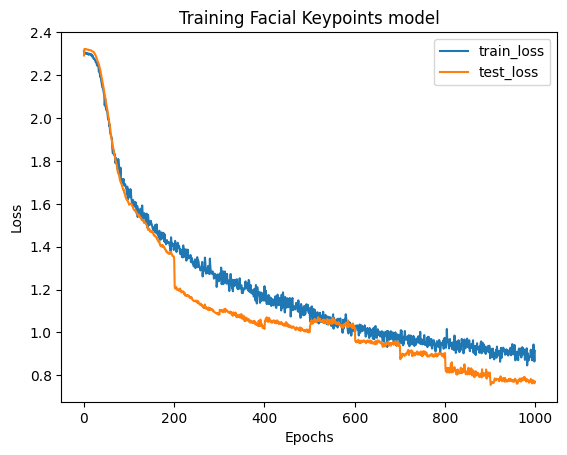

In [25]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

In [26]:
correct = 0
total = 0

Grasp_dataset_validation = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_validation/Grasp_dataset_validation.csv')
    

validation_dataset = ClassifierDataset(Grasp_dataset_validation)
    
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)


# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    classification_model.eval()
    for data in validation_dataloader:
        input_data, labels = data
        # calculate outputs by running images through the network
        outputs = classification_model(input_data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 100 test images: {100 * correct // total} %')


TypeError: new(): invalid data type 'str'